### Plot gnn results vs cpsat results either with same runtime or with same quality

In [12]:
import json
import csv

import pylab as p

# load results of gnn. change the paths to the files if you want to compare different data
# gnn_file = "inference_vs_sgspostpro_20221103131842.json"
gnn_file = "allinstances_inference_vs_sgspostpro_20230222175440.json"
cpsat_file = "cpsat_solutions.csv"
with open(gnn_file) as json_file:
    gnn_data = {entry["benchmark_id"]: entry for entry in json.load(json_file).values()}

with open(cpsat_file) as csv_file:
    reader = csv.reader(csv_file, delimiter=",")
    cpsat_data = [row for row in reader]

In [13]:
def get_closest_result(gnn_result, cpsat_results, cpsat_feature_idx, gnn_feature_name):
    # change these columns if the benchmark id of the cpsat can be found in another column
    cpsat_id_col = (0,)
    benchmark_id = gnn_result["benchmark_id"]
    feature = gnn_result[gnn_feature_name]
    matching_cp_results = [res for res in cpsat_results if float(res[cpsat_id_col[0]]) == benchmark_id]
    if len(matching_cp_results) == 0:
        raise RuntimeError(f"no cpsat results found for benchmark id {benchmark_id}")

    closest_match = matching_cp_results[0]
    for res in matching_cp_results:
        current_diff = abs(float(res[cpsat_feature_idx]) - feature)
        if current_diff < abs(float(closest_match[cpsat_feature_idx]) - feature):
            closest_match = res

    return closest_match

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import tikzplotlib


def scatter_plot(x, y, xlabel, ylabel, title, log_scale=False, save=None):
    x_max = max(x)
    x_min = min(x)
    y_max = max(y)
    y_min = min(y)
    id_x = np.linspace(max(x_min, y_min), min(x_max, y_max), 100)
    plt.scatter(x, y)
    plt.plot(id_x, id_x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(["", "y=x"])
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    if save:
        tikzplotlib.save(save)
    else:
        plt.show()


def hist_plot(data, xlabel, ylabel, title, save=None):
    res = plt.hist(data)
    mean = np.mean(data)
    sigma = np.std(data)
    x = np.linspace(min(data), max(data), 100)
    dx = res[1][1] - res[1][0]
    scale = len(data) * dx
    plt.plot(x, norm.pdf(x, mean, sigma) * scale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save:
        tikzplotlib.save(save)
    else:
        plt.show()

    print(f"avg: {np.mean(data)}, std: {np.std(data)}, min: {np.min(data)}, max: {np.max(data)}, median: {np.median(data)}")


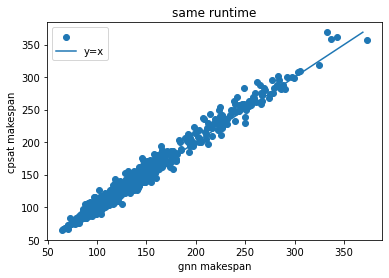

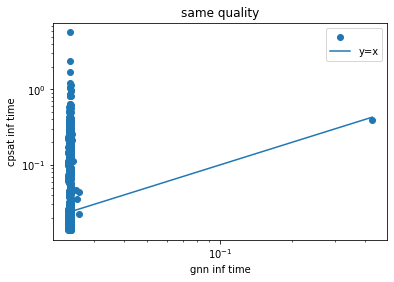

In [15]:
cpsat_inf_time_col = 1
cpsat_makespan_col = 3

gnn_results = [gnn_res["feasibility_abs_makespan"] for gnn_res in gnn_data.values()]
cpsat_baseline = [
    float(get_closest_result(gnn_res, cpsat_data, cpsat_inf_time_col, "inference_time")[cpsat_makespan_col]) for gnn_res
    in gnn_data.values()]
scatter_plot(gnn_results, cpsat_baseline, "gnn makespan", "cpsat makespan", "same runtime")

gnn_results = [gnn_res["inference_time"] for gnn_res in gnn_data.values()]
gnn_makespans = [res["feasibility_abs_makespan"] for res in gnn_data.values()]
cpsat_baseline = [
    float(get_closest_result(gnn_res, cpsat_data, cpsat_makespan_col, "feasibility_abs_makespan")[cpsat_inf_time_col])
    for gnn_res in gnn_data.values()]
scatter_plot(gnn_results, cpsat_baseline, "gnn inf time", "cpsat inf time", "same quality", log_scale=True)


In [16]:
num_better = np.sum([cp_rt >= gnn_rt for cp_rt, gnn_rt in zip(cpsat_baseline, gnn_results)])
print(f"GNN is faster than CP in {num_better / len(cpsat_baseline)}% instances")

GNN is faster than CP in 0.763095238095238% instances


runtime of gnn: min: 0.023354229051619768s, max: 0.42929085006471723s, mean: 0.024272104434064766, std: 0.013984281462386922, median: 0.023800180468242615
runtime of cpsat: min: 0.013660582015290856s, max: 5.696075402898714s, mean: 0.14502989799061436, std: 0.26681972738567605, median: 0.07635391992516816
relative runtime of cp when trying to achieve same quality as GNN + SGS
avg: 6.0710434037185195, std: 11.18074853255371, min: 0.56814928638534, max: 238.87640214537342, median: 3.1833595928860996


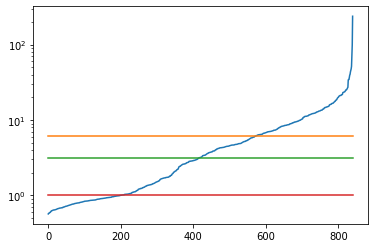

In [17]:
relative_runtime = [1 / (gnn_rt / cp_rt) for gnn_rt, cp_rt in zip(gnn_results, cpsat_baseline)]
print(f"runtime of gnn: min: {min(gnn_results)}s, max: {max(gnn_results)}s, "
      f"mean: {np.mean(gnn_results)}, std: {np.std(gnn_results)}, median: {np.median(gnn_results)}")
print(f"runtime of cpsat: min: {min(cpsat_baseline)}s, max: {max(cpsat_baseline)}s,"
      f" mean: {np.mean(cpsat_baseline)}, std: {np.std(cpsat_baseline)}, median: {np.median(cpsat_baseline)}")
print("relative runtime of cp when trying to achieve same quality as GNN + SGS")
print(
    f"avg: {np.mean(relative_runtime)}, std: {np.std(relative_runtime)}, min: {np.min(relative_runtime)}, max: {np.max(relative_runtime)}, median: {np.median(relative_runtime)}")
sorted_rel_rt = np.array(sorted(relative_runtime))
plt_data = sorted_rel_rt
x = np.arange(len(plt_data)) #/ len(plt_data)
plt.plot(x, plt_data)
plt.yscale('log')
plt.plot(x, [np.mean(sorted_rel_rt) for _ in range(len(plt_data))])
plt.plot(x, [np.median(sorted_rel_rt) for _ in range(len(plt_data))])
plt.plot(x, [1 for _ in range(len(plt_data))])
#plt.legend(["relative runtime of CP vs SIREN", "mean", "median", "equilibrium"])
#tikzplotlib.save("/home/tim/Documents/PhDToulouse/PhD/GNN4RCPSP/paper/tikz_plots/cp_time_overhead_same_quality_new.tex")
plt.show()

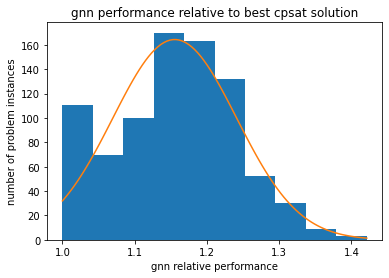

avg: 1.1554773606937276, std: 0.08588268565223367, min: 1.0, max: 1.4213483146067416, median: 1.1614532420984034


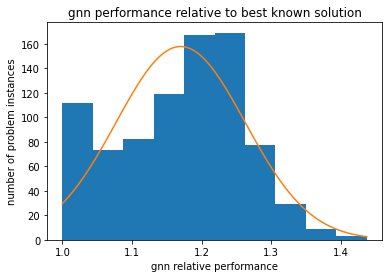

avg: 1.169934573861752, std: 0.09293567857780859, min: 1.0, max: 1.4375, median: 1.1844660194174756


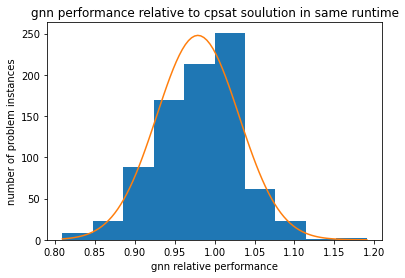

avg: 0.9790608148999045, std: 0.05152337968206762, min: 0.8095238095238095, max: 1.1904761904761905, median: 0.98268106162843


In [18]:
def get_best_cpsat_result(gnn_result, cpsat_results):
    cpsat_id_col = (0,)
    cpsat_runs = [res for res in cpsat_results if float(res[cpsat_id_col[0]]) == gnn_result["benchmark_id"]]
    return cpsat_runs[-1]


cpsat_best_results = [int(get_best_cpsat_result(gnn_res, cpsat_data)[cpsat_makespan_col]) for gnn_res in
                      gnn_data.values()]
gnn_rel_performance = [gnn_perf / cpsat_perf for gnn_perf, cpsat_perf in zip(gnn_makespans, cpsat_best_results)]
hist_plot(gnn_rel_performance, "gnn relative performance", "number of problem instances",
          "gnn performance relative to best cpsat solution")

gnn_rel_performance_vs_best = [res["feasibility_rel_makespan_ref"] for res in gnn_data.values()]
hist_plot(gnn_rel_performance_vs_best, "gnn relative performance", "number of problem instances",
          "gnn performance relative to best known solution")

cpsat_baseline = [
    float(get_closest_result(gnn_res, cpsat_data, cpsat_inf_time_col, "inference_time")[cpsat_makespan_col]) for gnn_res
    in gnn_data.values()]
gnn_rel_performance_same_time = [gnn_perf / cpsat_perf for gnn_perf, cpsat_perf in zip(gnn_makespans, cpsat_baseline)]
hist_plot(gnn_rel_performance_same_time, "gnn relative performance", "number of problem instances",
          "gnn performance relative to cpsat soulution in same runtime")
